Our approach for identifying poor-quality AI-generated exam items is by looking at the proportion of other (non-GPT4) models that selected the GPT4-selected "correct" answer. If the majority of a strong group of LLMs choose an answer other than the one that GPT-4 deems to be the "correct" answer, then that is evidence towards the GPT4-selected answer choice being "incorrect". Similarly, if there is no clear consensus among other LLM responses with respect to what the right answer choice should be, that is evidence that the GPT4-generated item may have flaws.

### Package Imports

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [2]:
import os
os.listdir()

['identifying_bad_ai_questions.ipynb']

### Copy the data from Carina

Data are located on Carina `/share/pi/nigam/scottyf/ai_generated_questions.csv` and are generated by calling `inference_single_model.sh`

In [3]:
# Located on Carina at /share/pi/nigam/scottyf/ai_generated_questions.csv
ai_generated_questions = pd.read_csv("~/Documents/GitHub/gpt4usmle/data/ai_generated_questions.csv")
ai_generated_output = pd.read_csv("~/Documents/GitHub/gpt4usmle/data/ai_generated_questions_output_20240722.csv")
ai_generated_output.groupby("model").size()

model
BioMistral-7B                   100
Llama3-Med42-70B                100
Llama3-OpenBioLLM-70B           100
Meta-Llama-3-70B-Instruct       100
Mistral-7B-Instruct-v0.3        100
Mixtral-8x22B-Instruct-v0.1     100
Phi-3-medium-4k-instruct        100
Qwen2-72B-Instruct              100
llama-2-70b-chat_huggingface    100
med42-70b                       100
dtype: int64

In [4]:
def pattern_search(s):
    match = re.search(r"\(([A-Z])\)", s)
    if match:
        return match[1]
    else:
        return None

ai_generated_output["candidate_answer_1"] = (
    ai_generated_output["model_answer"]
    .apply(lambda x: pattern_search(x))
)

ai_generated_output["candidate_answer_2"] = (
    ai_generated_output["model_answer"]
    .apply(lambda x: x.strip().strip("(")[0] if not pd.isnull(x) else "")
)

ai_generated_output['final_answer'] = (
    ai_generated_output['candidate_answer_1']
    .fillna(ai_generated_output['candidate_answer_2'])
)

In [5]:
ai_generated_output.loc[
    ai_generated_output["candidate_answer_1"] != ai_generated_output["candidate_answer_2"],
    ["model_answer", "candidate_answer_1", "candidate_answer_2", "final_answer"]
].head(10)

,model_answer,candidate_answer_1,candidate_answer_2,final_answer
100,D\n),None,D,D
101,A),None,A,A
102,D),None,D,D
103,D)\n),None,D,D
104,C\n),None,C,C
105,A),None,A,A
106,E)\nNo additional diagnostic studies are indic...,None,E,E
107,B)\n thoracentesis is the most appropriate nex...,None,B,B
108,B\n),None,B,B
109,D)\nSystemic lupus erythematosus,None,D,D


In [6]:
print(ai_generated_questions["ItemText_Raw"][0])

A 7-year-old boy is brought to the physician because of a 1-year history of poor performance in school. His parents say that he is bright, has many friends, and seems to want to do well in school. His teachers report that he seems frustrated with his own progress and his inability to meet the expectations of his parents. Speech fluency and articulation and motor skills are appropriate for age. Physical examination shows no abnormalities. When asked to read during the examination, he has significant difficulty sounding out words he is unfamiliar with. Visual acuity test and audiometry show no abnormalities. Which of the following is the most likely diagnosis?

(A) Attention-deficit/hyperactivity disorder
(B) Expressive language disorder
(C) Intellectual developmental disorder
(D) Learning disorder
(E) Social anxiety disorder (social phobia)
(F) Normal behavior


In [7]:
ai_generated_output.loc[ai_generated_output["model_answer"].isnull(), "model"].unique()

array([], dtype=object)

In [8]:
ai_generated_output.loc[ai_generated_output["model_answer"].isnull(), :].groupby("model").count()

,item_num,gt_answer,model_answer,candidate_answer_1,candidate_answer_2,final_answer
model,,,,,,


### Filter down to just the best-performing models

In [9]:
human_generated_questions = ai_generated_output.loc[ai_generated_output["item_num"].str.endswith("H"), :].copy()
human_generated_questions["model_is_correct"] = human_generated_questions["final_answer"] == human_generated_questions["gt_answer"]
model_perf_df = (
    human_generated_questions
    .groupby("model")
    .agg(pct_correct = ("model_is_correct", "mean"))
    .reset_index()
    .sort_values("pct_correct", ascending=False)
)
model_perf_df

,model,pct_correct
1,Llama3-Med42-70B,0.80
3,Meta-Llama-3-70B-Instruct,0.80
5,Mixtral-8x22B-Instruct-v0.1,0.80
7,Qwen2-72B-Instruct,0.80
2,Llama3-OpenBioLLM-70B,0.76
6,Phi-3-medium-4k-instruct,0.76
9,med42-70b,0.66
8,llama-2-70b-chat_huggingface,0.60
4,Mistral-7B-Instruct-v0.3,0.52
0,BioMistral-7B,0.28


In [10]:
ai_generated_output = ai_generated_output[
    ai_generated_output['model'].isin([
        # 'Qwen1.5-72B-Chat', 
        # 'Mixtral-8x7B-Instruct-v0.1', 
        # 'Mistral-7B-Instruct-v0.2', 
        # 'zephyr-7b-beta'
        
        # "Llama3-Med42-70B",
        "Meta-Llama-3-70B-Instruct",
        "Mixtral-8x22B-Instruct-v0.1",
        "Qwen2-72B-Instruct",
        # "Llama3-OpenBioLLM-70B",
        "Phi-3-medium-4k-instruct",
        # "med42-70b",
        "llama-2-70b-chat_huggingface",
        # "Mistral-7B-Instruct-v0.3"
    ])
]

### Define what is a "good" vs. "bad" AI-generated question using clinician labels

We had 2 clinicians review each AI-generated question and decide whether it was a "good" question or a "bad" question. Often there was consensus, but sometimes it was 50/50. For this analysis, we take the view that if *any* clinician deemed that an AI-generated question was "bad" then it was indeed "bad".

In [11]:
is_good_qa = ai_generated_questions[['ItemNum', 'true_human_or_GPT4', 'ItemText_Raw']].copy()
is_good_qa['is_bad_strict'] = ai_generated_questions['consensus_is_gpt_qa_correct'] == 'no'
is_good_qa['is_bad_relaxed'] = ai_generated_questions['consensus_is_gpt_qa_correct'].isin(['no', '50/50'])
is_good_qa['consensus_reason'] = ai_generated_questions['consensus_reason']
is_good_qa.tail()

,ItemNum,true_human_or_GPT4,ItemText_Raw,is_bad_strict,is_bad_relaxed,consensus_reason
95,059G,GPT,A 27-year-old woman visits her primary care ph...,False,True,Multiple correct answers
96,110H,human,A 45-year-old man is brought to the emergency ...,False,False,NaN
97,065H,human,A 2-week-old boy is evaluated in the neonatal ...,False,False,NaN
98,028G,GPT,A 35-year-old woman presents to the emergency ...,False,True,AI-chosen answer is incorrect
99,091G,GPT,A 65-year-old man presents to the primary care...,True,True,Multiple correct answers


### Calculate proportion of models that selected each answer choice

In [12]:
ai_questions_answer_probabilities_df = ai_generated_output.groupby('item_num').agg(
    prop_A = ('final_answer', lambda x: (x == 'A').mean()),
    prop_B = ('final_answer', lambda x: (x == 'B').mean()),
    prop_C = ('final_answer', lambda x: (x == 'C').mean()),
    prop_D = ('final_answer', lambda x: (x == 'D').mean()),
    prop_E = ('final_answer', lambda x: (x == 'E').mean()),
    prop_F = ('final_answer', lambda x: (x == 'F').mean()),
    prop_G = ('final_answer', lambda x: (x == 'G').mean()),
    prop_H = ('final_answer', lambda x: (x == 'H').mean()),
    correct_answer = ('gt_answer', 'first')
)
ai_questions_answer_probabilities_df = (
    ai_questions_answer_probabilities_df
    .reset_index()
    .merge(is_good_qa, left_on='item_num', right_on='ItemNum')
)
ai_questions_answer_probabilities_df.head()

,item_num,prop_A,prop_B,prop_C,prop_D,prop_E,prop_F,prop_G,prop_H,correct_answer,ItemNum,true_human_or_GPT4,ItemText_Raw,is_bad_strict,is_bad_relaxed,consensus_reason
0,006G,0.0,0.8,0.2,0.0,0.0,0.0,0.0,0.0,B,006G,GPT,A 36-year-old man presents to the emergency de...,True,True,Multiple correct answers
1,006H,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,006H,human,A previously healthy 29-year-old woman is admi...,False,False,NaN
2,007G,0.0,0.0,0.0,0.8,0.2,0.0,0.0,0.0,D,007G,GPT,"A 32-year-old gravida 2, para 1 woman presents...",False,False,NaN
3,007H,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,D,007H,human,A 27-year-old primigravid woman comes to the p...,False,False,NaN
4,009G,0.0,0.4,0.4,0.2,0.0,0.0,0.0,0.0,B,009G,GPT,A 45-year-old woman presents to the emergency ...,False,False,NaN


### Calculate proportion of LLMs that selected the GPT4-selected "Answer"

In [13]:
ai_questions_llm_response_probs_df = []

for i, row in ai_questions_answer_probabilities_df.iterrows():
    if row['true_human_or_GPT4'] == 'human':
        continue
    majority_vote = None
    max_vote = -np.inf
    for answer_choice in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        if row[f'prop_{answer_choice}'] > max_vote:
            majority_vote = answer_choice
            max_vote = row[f'prop_{answer_choice}']
    the_correct_answer = row['correct_answer']
    new_row = {
        'ItemNum': row['ItemNum'],
        'ItemText_Raw': row['ItemText_Raw'],
        'majority_vote': majority_vote,
        'prop_llms_in_majority': max_vote,
        'correct_answer': the_correct_answer,
        'prop_llms_correct': row[f'prop_{the_correct_answer}'],
        'true_human_or_GPT4': row['true_human_or_GPT4'],
        'is_bad_strict': row['is_bad_strict'],
        'is_bad_relaxed': row['is_bad_relaxed'],
        'consensus_reason': row['consensus_reason']
    }
    ai_questions_llm_response_probs_df.append(new_row)

ai_questions_llm_response_probs_df = pd.DataFrame(ai_questions_llm_response_probs_df).sort_values('prop_llms_correct')
ai_questions_llm_response_probs_df.head()

,ItemNum,ItemText_Raw,majority_vote,prop_llms_in_majority,correct_answer,prop_llms_correct,true_human_or_GPT4,is_bad_strict,is_bad_relaxed,consensus_reason
46,111G,A 27-year-old woman presents to the clinic wit...,B,0.4,A,0.0,GPT,False,True,No correct answer
15,043G,A 62-year-old woman presents to the clinic wit...,C,1.0,A,0.0,GPT,False,True,AI-chosen answer is incorrect
22,063G,"A 28-year-old woman, gravida 3, para 3, presen...",D,0.8,E,0.0,GPT,True,True,AI-chosen answer is incorrect
29,075G,A 12-year-old boy is brought to the pediatrici...,D,0.8,C,0.2,GPT,False,False,NaN
20,061G,A 56-year-old man presents to the clinic with ...,A,0.8,E,0.2,GPT,False,True,Multiple correct answers


In [14]:
# target = "is_bad_strict"
target = "is_bad_relaxed"
metric = "prop_llms_correct"
# metric = "prop_llms_in_majority"

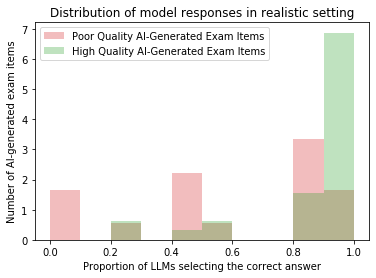

In [15]:
bins = np.linspace(0, 1, 11)
plt.hist(
    ai_questions_llm_response_probs_df.loc[ai_questions_llm_response_probs_df[target] == 1, metric],
    bins=bins,
    color='tab:red',
    alpha=0.3,
    label='Poor Quality AI-Generated Exam Items',
    density=True
)
plt.hist(
    ai_questions_llm_response_probs_df.loc[ai_questions_llm_response_probs_df[target] == 0, metric],
    bins=bins,
    color='tab:green',
    alpha=0.3,
    label='High Quality AI-Generated Exam Items',
    density=True
)
plt.title('Distribution of model responses in realistic setting')
plt.xlabel('Proportion of LLMs selecting the correct answer')
plt.ylabel('Number of AI-generated exam items')
plt.legend()
plt.show()

### Classify AI-generated as good vs. bad based on proportion of LLMs that selected GPT4-chosen answer

In [16]:
print("Ability of LLM ensemble to detect poor quality AI-generated questions in realistic setting")
for thresh in np.linspace(0.01, 1, 11):
    y_true = ai_questions_llm_response_probs_df[target]  # Whether the answer choice was incorrect
    # y_pred = ai_questions_llm_response_probs_df['prop_llms_in_majority'] < thresh
    y_pred = (1-ai_questions_llm_response_probs_df[metric]) > thresh
    # y_pred = np.logical_and(
    #     ai_questions_llm_response_probs_df['prop_llms_in_majority'] < thresh, 
    #     ai_questions_llm_response_probs_df['prop_llms_correct'] < thresh, 
    # )
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    print(f"threshold={thresh:.2f}, precision={precision:.2f}, recall={recall:.2f}")

auroc = roc_auc_score(
    ai_questions_llm_response_probs_df[target], 
    1-ai_questions_llm_response_probs_df[metric]
)
print(f"AUROC = {auroc}")

Ability of LLM ensemble to detect poor quality AI-generated questions in realistic setting
threshold=0.01, precision=0.60, recall=0.83
threshold=0.11, precision=0.60, recall=0.83
threshold=0.21, precision=0.64, recall=0.50
threshold=0.31, precision=0.64, recall=0.50
threshold=0.41, precision=0.73, recall=0.44
threshold=0.51, precision=0.73, recall=0.44
threshold=0.60, precision=0.67, recall=0.22
threshold=0.70, precision=0.67, recall=0.22
threshold=0.80, precision=1.00, recall=0.17
threshold=0.90, precision=1.00, recall=0.17
threshold=1.00, precision=0.00, recall=0.00
AUROC = 0.7864583333333334


/Users/scottyf/anaconda3/envs/youper/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
thresh = 0.80
y_true = ai_questions_llm_response_probs_df[target]
y_pred = ai_questions_llm_response_probs_df[metric] <= thresh
precision = precision_score(y_true=y_true, y_pred=y_pred)
recall = recall_score(y_true=y_true, y_pred=y_pred)
print(f"Num AI-generated questions that are actually bad = {y_true.sum()}")
print(f"Num AI-generated questions that are predicted bad = {y_pred.sum()}")
print(f"threshold={thresh:.2f}, precision={precision:.2f}, recall={recall:.2f}")

Num AI-generated questions that are actually bad = 18
Num AI-generated questions that are predicted bad = 25
threshold=0.80, precision=0.60, recall=0.83


In [18]:
# We said the question was not fine but it was actually fine
false_positives = ai_questions_llm_response_probs_df.loc[
    (ai_questions_llm_response_probs_df[metric] <= thresh) &
    (ai_questions_llm_response_probs_df["is_bad_relaxed"] == False)
]
len(false_positives)


10

In [19]:
# We said the question was not fine 
true_positives = ai_questions_llm_response_probs_df.loc[
    (ai_questions_llm_response_probs_df[metric] <= thresh) &
    (ai_questions_llm_response_probs_df["is_bad_relaxed"] == True)
]
len(true_positives)

15

In [20]:
15 / (15 + 10.)

0.6

In [21]:
# We said the question was fine and it was fine
true_negatives = ai_questions_llm_response_probs_df.loc[
    (ai_questions_llm_response_probs_df[metric] > thresh) &
    (ai_questions_llm_response_probs_df["is_bad_relaxed"] == False)
]
len(true_negatives)

22

In [22]:
# We said the question was fine but it actually had problems
false_negatives = ai_questions_llm_response_probs_df.loc[
    (ai_questions_llm_response_probs_df[metric] > thresh) &
    (ai_questions_llm_response_probs_df["is_bad_relaxed"] == True)
]
len(false_negatives)

3

In [23]:
false_negatives

,ItemNum,ItemText_Raw,majority_vote,prop_llms_in_majority,correct_answer,prop_llms_correct,true_human_or_GPT4,is_bad_strict,is_bad_relaxed,consensus_reason
42,104G,A 36-year-old woman presents to the clinic wit...,B,1.0,B,1.0,GPT,False,True,Multiple correct answers
6,028G,A 35-year-old woman presents to the emergency ...,C,1.0,C,1.0,GPT,False,True,AI-chosen answer is incorrect
36,091G,A 65-year-old man presents to the primary care...,C,1.0,C,1.0,GPT,True,True,Multiple correct answers


In [25]:
print(ai_questions_llm_response_probs_df.loc[
    ai_questions_llm_response_probs_df["ItemNum"] == "028G",
    "ItemText_Raw"
].item())

A 35-year-old woman presents to the emergency department with severe abdominal pain and vomiting for the past 6 hours. She reports that the pain started suddenly and is located in the right lower quadrant. She has no significant past medical history and is not currently taking any medications. She has no known drug allergies. She is 165 cm (5 ft 5 in) tall and weighs 68 kg (150 lb); BMI is 25 kg/m². Temperature is 38.2°C (100.8°F), pulse is 110/min, respirations are 20/min, and blood pressure is 115/75 mm Hg. Physical examination reveals rebound tenderness and guarding in the right lower quadrant. Laboratory studies show a white blood cell count of 15,000/mm³. Which of the following is the most appropriate next step in management?

(A) Administer intravenous fluids and antiemetics
(B) Administer intravenous morphine for pain control
(C) Obtain a surgical consultation for suspected appendicitis
(D) Perform an abdominal ultrasound
(E) Prescribe oral antibiotics for suspected gastroenteri

In [26]:
print(ai_questions_llm_response_probs_df.loc[
    ai_questions_llm_response_probs_df["ItemNum"] == "091G",
    "ItemText_Raw"
].item())

A 65-year-old man presents to the primary care clinic for a follow-up visit after being discharged from the hospital 1 week ago due to a myocardial infarction. The patient has a history of type 2 diabetes mellitus and hypertension, which are managed with metformin, lisinopril, and hydrochlorothiazide. Since discharge, he has been prescribed atorvastatin, metoprolol, and aspirin. He reports mild shortness of breath on exertion and occasional chest discomfort. Vital signs reveal a temperature of 36.7°C (98.1°F), pulse of 68/min, respirations of 16/min, and blood pressure of 128/78 mm Hg. Cardiac examination shows regular rate and rhythm with no murmurs, rubs, or gallops. Pulmonary examination reveals clear breath sounds bilaterally. Laboratory results show a fasting glucose level of 140 mg/dL, HbA1c of 7.8%, and a lipid panel with an LDL cholesterol of 100 mg/dL. The patient lives alone, but his adult children live nearby and visit him regularly. What is the most appropriate next step in